In [1]:
from PIL import Image
from numpy import asarray, argmax, array

LABELS = ('circle', 'line', 'arch')


def get_one_hot(label):
    result = [0] * len(LABELS)
    result[LABELS.index(label)] = 1
    return result


def get_label(one_hot):
    return LABELS[argmax(one_hot)]


def __to2d__(img):
    result = img.convert('L')
    result = asarray(result)
    x = []
    for row in result:
        we = []
        x.append(we)
        for value in row:
            we.append(1 - value / 255)
    return array(x).reshape(28, 28, 1)


class Figure:
    def __init__(self, image, label) -> None:
        super().__init__()
        self.image = image.resize((28, 28), Image.ANTIALIAS)
        self.label = label
        self.encoding = __to2d__(image)
        self.one_hot = get_one_hot(label)

In [2]:
from os import walk
from PIL import Image

def get_data(path):
    data = []
    for (dir_path, dir_names, file_names) in walk(path):
        for dir_name in dir_names:

            for (fig_path, fig_dirs, figs) in walk(dir_path + '/' + dir_name):
                for fig in figs:
                    image = Image.open(fig_path + '/' + fig).resize((28, 28), Image.ANTIALIAS)
                    data.append(Figure(image, dir_name))

    return data

In [17]:
import matplotlib.pyplot as plt
from numpy import amax

def plot_images(figures_to_show, cls_pred=None):
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, int(len(figures_to_show) / 3), figsize=(15, 5))
#     fig.subplots_adjust(hspace=0.3, wspace=3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        if i < len(figures_to_show):
            figure = figures_to_show[i]
            ax.imshow(figure.image)

            # Show true and predicted classes.
            if cls_pred is None:
                label = "{0}".format(figure.label)
            else:
                confidence = int(amax(cls_pred[i]) * 100)
                label = "{0} vs {1}, {2}%".format(figure.label, get_label(cls_pred[i]), confidence)
                if(figure.label != get_label(cls_pred[i])):
                    ax.xaxis.label.set_color('red')

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(label)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [4]:
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import tensorflow as tf
import time

activations = ('relu', 'tanh')
optimizers = ('sgd', 'adam')
losses = ('categorical_crossentropy', 'whatever')
regulizers = ('L1', 'L2')

def create_network(params):
    network = input_data(shape=[None, 28, 28, 1], name='input', dtype=tf.float32)
    layer_n = 0
    for p in params[:-1]:
        layer_n = layer_n + 1
        layer_type = p[0]
        shape = p[1]
        activation = activations[p[2]]
        regulizer = regulizers[p[3]]
        drpt = p[4]
        fltr = p[5]
        max_pool = p[6]

        if layer_type == 0:
            layer_name = 'fc_' + str(layer_n)
            print('Create layer {} with shape: {}, activation: {}, dropout: {}'
                  .format(layer_name, shape, activation, drpt))
            network = fully_connected(network, shape,
                                      activation=activation,
                                      name=layer_name)
            network = dropout(network, drpt)
        elif layer_type == 1:
            layer_name = 'conv_' + str(layer_n)
            print('Create layer {} with shape: {}, activation: {}, regularizer: {}, filter: {}, max_pool: {}'
                  .format(layer_name, shape, activation, regulizer, fltr, max_pool))
            network = conv_2d(network, shape, fltr,
                              activation=activation,
                              regularizer=regulizer,
                              name=layer_name)
            network = max_pool_2d(network, p[6])
            network = local_response_normalization(network)

    network = fully_connected(network, 3, activation='softmax', name='prob')

    optimizer = optimizers[params[-1][0]]
    learning_rate = params[-1][1]
    loss = losses[params[-1][2]]
    print('Add regression {} at {} with {}'.format(optimizer, learning_rate, loss))
    network = regression(network,
                         optimizer=optimizer,
                         learning_rate=learning_rate,
                         loss=loss,
                         name='target')

    return network


def fit(train, test, epoch, params):
    run_id = str(int(time.time())) + '_' + str(len(params))
    print('Fit ' + run_id)
    
    train_x = array([t.encoding for t in train])
    train_y = array([t.one_hot for t in train])

    test_x = array([t.encoding for t in test])
    test_y = array([t.one_hot for t in test])

    with tf.Graph().as_default():
        network = create_network(params)
        model = tflearn.DNN(network, tensorboard_verbose=3, tensorboard_dir='board')
        model.fit({'input': train_x}, {'target': train_y}, n_epoch=epoch,
                  validation_set=({'input': test_x}, {'target': test_y}),
                  snapshot_step=100, show_metric=True, run_id=run_id)

        save_path = 'models/' + run_id
        model.save(save_path)

        return network, save_path, model.predict(test_x)

In [5]:
train = get_data('figures')
test = get_data('objects')

In [6]:
prediction = fit(train, test, 100, (
        (1,32, 0,1,0,  3,2),   
        (1,64, 0,1,0,  3,2),    
        (0,256,1,0,0.8,0,0),
        (0,128,1,0,0.8,0,0),
        (1, 0.01, 0)
    ))

Fit 1503254262_5
Create layer conv_1 with shape: 32, activation: relu, regularizer: L2, filter: 3, max_pool: 2
Create layer conv_2 with shape: 64, activation: relu, regularizer: L2, filter: 3, max_pool: 2
Create layer fc_3 with shape: 256, activation: tanh, dropout: 0.8
Create layer fc_4 with shape: 128, activation: tanh, dropout: 0.8
Add regression adam at 0.01 with categorical_crossentropy
---------------------------------
Run id: 1503254262_5
Log directory: board/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 61
Validation samples: 25
--
Training Step: 1  | time: 2.524s
| Adam | epoch: 001 | loss: 0.00000 - acc: 0.0000 | val_loss: 1.06074 - val_acc: 0.4800 -- iter: 61/61
--
Training Step: 2  | total loss: 0.98715 | time: 2.997s
| Adam | epoch: 002 | loss: 0.98715 - acc: 0.3393 | val_loss: 1.56079 - val_acc: 0.4400 -- iter: 61/61
--
Training Step: 3  | total loss: 1.19545 | time: 2.814s
| Ad

Training Step: 44  | total loss: 0.18166 | time: 2.666s
| Adam | epoch: 044 | loss: 0.18166 - acc: 0.9606 | val_loss: 0.31897 - val_acc: 0.8400 -- iter: 61/61
--
Training Step: 45  | total loss: 0.15957 | time: 2.589s
| Adam | epoch: 045 | loss: 0.15957 - acc: 0.9673 | val_loss: 0.28800 - val_acc: 0.8800 -- iter: 61/61
--
Training Step: 46  | total loss: 0.14139 | time: 2.602s
| Adam | epoch: 046 | loss: 0.14139 - acc: 0.9727 | val_loss: 0.29983 - val_acc: 0.8800 -- iter: 61/61
--
Training Step: 47  | total loss: 0.12475 | time: 2.438s
| Adam | epoch: 047 | loss: 0.12475 - acc: 0.9772 | val_loss: 0.28850 - val_acc: 0.9200 -- iter: 61/61
--
Training Step: 48  | total loss: 0.11418 | time: 2.609s
| Adam | epoch: 048 | loss: 0.11418 - acc: 0.9809 | val_loss: 0.33531 - val_acc: 0.8800 -- iter: 61/61
--
Training Step: 49  | total loss: 0.10147 | time: 2.786s
| Adam | epoch: 049 | loss: 0.10147 - acc: 0.9839 | val_loss: 0.37158 - val_acc: 0.8800 -- iter: 61/61
--
Training Step: 50  | total l

Training Step: 90  | total loss: 0.10211 | time: 2.819s
| Adam | epoch: 090 | loss: 0.10211 - acc: 0.9880 | val_loss: 0.33123 - val_acc: 0.8800 -- iter: 61/61
--
Training Step: 91  | total loss: 0.09379 | time: 2.906s
| Adam | epoch: 091 | loss: 0.09379 - acc: 0.9892 | val_loss: 0.30841 - val_acc: 0.8800 -- iter: 61/61
--
Training Step: 92  | total loss: 0.08625 | time: 2.560s
| Adam | epoch: 092 | loss: 0.08625 - acc: 0.9903 | val_loss: 0.28818 - val_acc: 0.8800 -- iter: 61/61
--
Training Step: 93  | total loss: 0.07889 | time: 2.142s
| Adam | epoch: 093 | loss: 0.07889 - acc: 0.9912 | val_loss: 0.27374 - val_acc: 0.9200 -- iter: 61/61
--
Training Step: 94  | total loss: 0.07238 | time: 2.857s
| Adam | epoch: 094 | loss: 0.07238 - acc: 0.9921 | val_loss: 0.27284 - val_acc: 0.9200 -- iter: 61/61
--
Training Step: 95  | total loss: 0.06696 | time: 3.037s
| Adam | epoch: 095 | loss: 0.06696 - acc: 0.9929 | val_loss: 0.26989 - val_acc: 0.8800 -- iter: 61/61
--
Training Step: 96  | total l

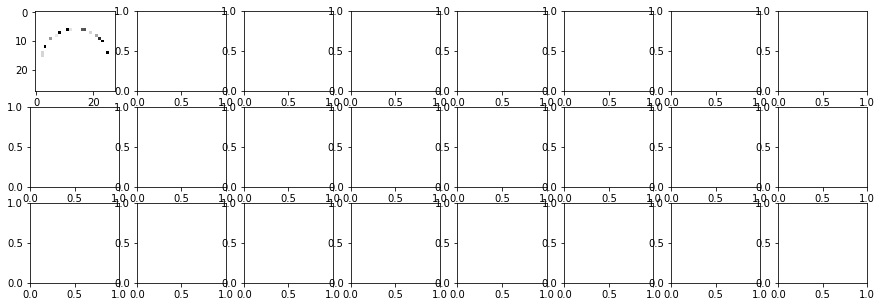

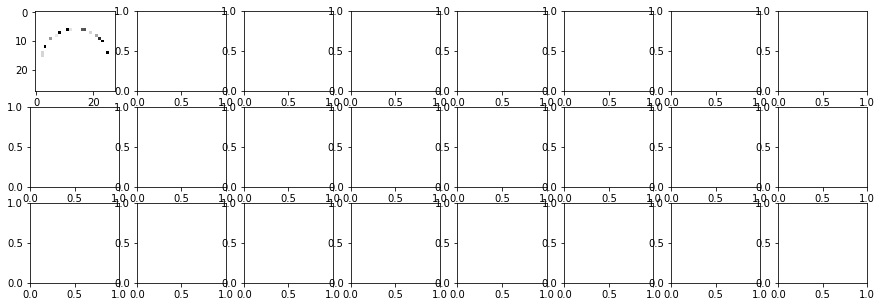

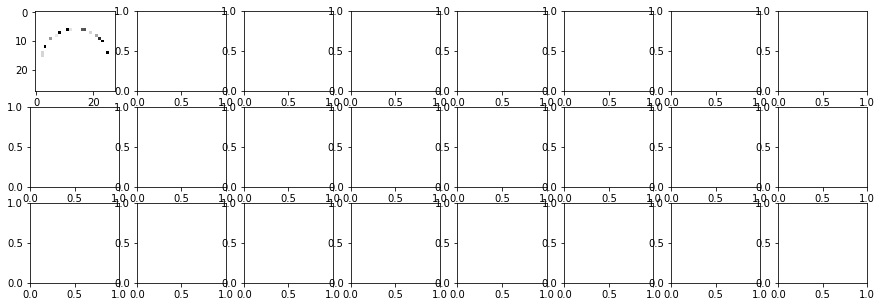

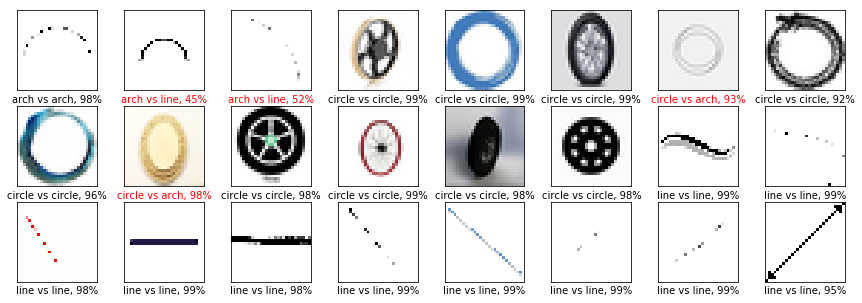

In [18]:
plot_images(test, prediction[2])

In [11]:
with tf.Graph().as_default():
    model = tflearn.DNN(create_network((
        (1,32, 0,1,0,  3,2),   
        (1,64, 0,1,0,  3,2),    
        (0,256,1,0,0.8,0,0),
        (0,128,1,0,0.8,0,0),
        (1, 0.01, 0)
    )), tensorboard_verbose=3, tensorboard_dir='board')
    model.load(prediction[1])
    print(model.predict(array([t.encoding for t in test])))

Create layer conv_1 with shape: 32, activation: relu, regularizer: L2, filter: 3, max_pool: 2
Create layer conv_2 with shape: 64, activation: relu, regularizer: L2, filter: 3, max_pool: 2
Create layer fc_3 with shape: 256, activation: tanh, dropout: 0.8
Create layer fc_4 with shape: 128, activation: tanh, dropout: 0.8
Add regression adam at 0.01 with categorical_crossentropy
INFO:tensorflow:Restoring parameters from C:\Users\etashkinov\PycharmProjects\neurogene\models\1503254262_5
[[0.006303918082267046, 0.004148869775235653, 0.9895471334457397], [0.13108663260936737, 0.4563351273536682, 0.412578284740448], [0.043435994535684586, 0.5259256958961487, 0.4306383728981018], [0.993708610534668, 0.0036392570473253727, 0.002652107970789075], [0.9931297898292542, 0.0035884163808077574, 0.003281819401308894], [0.9936445951461792, 0.00350294285453856, 0.002852445701137185], [0.05748499184846878, 0.011805839836597443, 0.9307091236114502], [0.9294236302375793, 0.012790151871740818, 0.0577861890196

In [ ]:
print(model.predict(array([t.encoding for t in test[0:1]])))